# Reading Data from External API

Often you want to add external data to your analysis. External data can be retrieved from API (Application Programable Interface) that is provided by various services such as CRM (Customer Relationship Management) systems. You can import HTML directly into Excel using _"Import"_.

In this notebook, we will learn how to use pandas _from_dict_ to load data from these external API

## Loading API data

We will load a few tables from simple API as well as complex ones

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
import numpy as np

## Loading from simple API

If you have a simple API with no authentication, you can pass the URL of the requests library that we used in our previous toturial for loading HTML

For this excercise we will use the API of the Wikipedia page views. We will use it to test the idea that people who are thinking to buy stocks, are going to the wikipedia page of that stock, and therefore, if we see an increase in the views of a page, we will see an increase in the price of that share. 

We will check the format of the API call from the [technical page](https://www.mediawiki.org/wiki/API:Tutorial). We see the we need to plug the name of stock ticker, and we will use the f-string syntax that is replacing the {page} (or any other variable in curly brackets) with the value of the variable (for example, _AMZN_).

In [7]:
page = 'AMZN'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

page_views_api_url = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{page}/daily/2020030100/2020033000'

import requests
response = requests.get(page_views_api_url, headers=header)
response

<Response [200]>

We can use two methods to extract the data that we want from the JSON format. The first is using _json_normalize_ and the second is using _from_dict_

In [8]:
df = (
    pd
    .json_normalize(
        response.json(), 
        'items'
        )
)
df.head(5)

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,AMZN,daily,2020030100,all-access,all-agents,2
1,en.wikipedia,AMZN,daily,2020030200,all-access,all-agents,6
2,en.wikipedia,AMZN,daily,2020030300,all-access,all-agents,16
3,en.wikipedia,AMZN,daily,2020030400,all-access,all-agents,1
4,en.wikipedia,AMZN,daily,2020030500,all-access,all-agents,1


In [9]:
page_view_data = (
    requests
    .get(page_views_api_url, headers=header)
    .json()['items']
)
page_views_table = (
    pd
    .DataFrame
    .from_dict(page_view_data)
)
page_views_table.head(5)

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,AMZN,daily,2020030100,all-access,all-agents,2
1,en.wikipedia,AMZN,daily,2020030200,all-access,all-agents,6
2,en.wikipedia,AMZN,daily,2020030300,all-access,all-agents,16
3,en.wikipedia,AMZN,daily,2020030400,all-access,all-agents,1
4,en.wikipedia,AMZN,daily,2020030500,all-access,all-agents,1


## Simple Data Visualization

* Start with the page view table from the previous API call
* Convert the timestamp column to date time format using the _%Y%m%d%H_ format
* Extract the day of the month from the above timestamp
* Plot the results
* as bar chart with the day of the month as x and the number of views as y 
* and title the graph as 'Page views for ...' with the name of the page



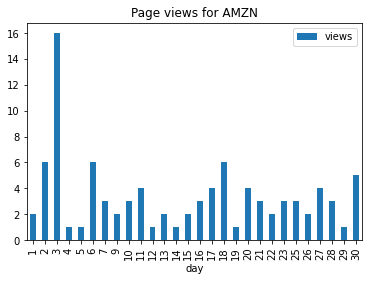

In [10]:
(
    page_views_table
    .assign(timestamp = lambda x: pd.to_datetime(x.timestamp, format='%Y%m%d%H', errors='coerce'))
    .assign(day = lambda x: x.timestamp.dt.day)
    .plot
    .bar(
        x='day', y='views',
        title=f'Page views for {page}'
    )
);

## Loading the page views of all NASDAQ 100

We saw in the previous section how to load the values of a table from Wikipeia (or other HTML pages). Let's use it now to load all the NASDAQ 100 index companies to compare their page views.

In [11]:
nasdaq_100_wikipedia_entry = 'https://en.wikipedia.org/wiki/NASDAQ-100'
nasdaq_100_tickers = (
    pd
    .read_html(
        nasdaq_100_wikipedia_entry, 
        match='Ticker'
    )
)

In [12]:
nasdaq_100_tickers[0]

,Company,Ticker,GICS Sector,GICS Sub-Industry
0,Activision Blizzard,ATVI,Communication Services,Interactive Home Entertainment
1,Adobe Inc.,ADBE,Information Technology,Application Software
2,Advanced Micro Devices,AMD,Information Technology,Semiconductors
3,Alexion Pharmaceuticals,ALXN,Health Care,Pharmaceuticals
4,Align Technology,ALGN,Health Care,Health Care Supplies
...,...,...,...,...
97,"Walgreen Boots Alliance, Inc.",WBA,Consumer Staples,Drug Retail
98,"Workday, Inc.",WDAY,Information Technology,Application Software
99,Xcel Energy Inc.,XEL,Utilities,Multi-Utilities
100,"Xilinx, Inc.",XLNX,Information Technology,Semiconductors


Now we want to get all the views of each company on our list. We will define a simple function that will get the name of the company and return the views of this company's page.
* Generate the URL of the wikipedia page view using the name of the company
* Load the API response from above URL
* Parse the JSON format of the response using the key 'items'
* Return the newly create dataframe or an empty data frame if failed

In [13]:
def get_views(company):
    company_page_url = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{company.iat[0,0]}/daily/2020090100/2020093000'
    response = requests.get(company_page_url, headers=header)
    try:
        df = (
            pd
            .json_normalize(
                response.json(), 
                'items'
            )
        )
    except:
        df = pd.DataFrame()
    
    return df

Now we can apply the function above on each of the row from the nasdaq 100 tickets list:
* Start with the first table from the nasdaq 100 list above
* Group the ticker by the company name (in case we have multiple ticker to a company)
* Apply the get view function on each of the company names and concat all the data frames together

In [14]:
nasdaq_100_views = (
    nasdaq_100_tickers[0]
    .head(2)
    .groupby('Company')[['Company']]
    .apply(get_views)
)

In [15]:
nasdaq_100_views

project              article granularity  \
Company                                                                 
Activision Blizzard 0   en.wikipedia  Activision_Blizzard       daily   
                    1   en.wikipedia  Activision_Blizzard       daily   
                    2   en.wikipedia  Activision_Blizzard       daily   
                    3   en.wikipedia  Activision_Blizzard       daily   
                    4   en.wikipedia  Activision_Blizzard       daily   
                    5   en.wikipedia  Activision_Blizzard       daily   
                    6   en.wikipedia  Activision_Blizzard       daily   
                    7   en.wikipedia  Activision_Blizzard       daily   
                    8   en.wikipedia  Activision_Blizzard       daily   
                    9   en.wikipedia  Activision_Blizzard       daily   
                    10  en.wikipedia  Activision_Blizzard       daily   
                    11  en.wikipedia  Activision_Blizzard       daily   
                    12  en.wikipedia  Activision_Blizzard       daily   
                    13  en.wikipedia  Activision_Blizzard       daily   
                    14  en.wikipedia  Activision_Blizzard       daily   
                    15  en.wikipedia  Activision_Blizzard       daily   
                    16  en.wikipedia  Activision_Blizzard       daily   
                    17  en.wikipedia  Activision_Blizzard       daily   
                    18  en.wikipedia  Activision_Blizzard       daily   
                    19  en.wikipedia  Activision_Blizzard       daily   
                    20  en.wikipedia  Activision_Blizzard       daily   
                    21  en.wikipedia  Activision_Blizzard       daily   
                    22  en.wikipedia  Activision_Blizzard       daily   
                    23  en.wikipedia  Activision_Blizzard       daily   
                    24  en.wikipedia  Activision_Blizzard       daily   
                    25  en.wikipedia  Activision_Blizzard       daily   
                    26  en.wikipedia  Activision_Blizzard       daily   
                    27  en.wikipedia  Activision_Blizzard       daily   
                    28  en.wikipedia  Activision_Blizzard       daily   
                    29  en.wikipedia  Activision_Blizzard       daily   
Adobe Inc.          0   en.wikipedia           Adobe_Inc.       daily   
                    1   en.wikipedia           Adobe_Inc.       daily   
                    2   en.wikipedia           Adobe_Inc.       daily   
                    3   en.wikipedia           Adobe_Inc.       daily   
                    4   en.wikipedia           Adobe_Inc.       daily   
                    5   en.wikipedia           Adobe_Inc.       daily   
                    6   en.wikipedia           Adobe_Inc.       daily   
                    7   en.wikipedia           Adobe_Inc.       daily   
                    8   en.wikipedia           Adobe_Inc.       daily   
                    9   en.wikipedia           Adobe_Inc.       daily   
                    10  en.wikipedia           Adobe_Inc.       daily   
                    11  en.wikipedia           Adobe_Inc.       daily   
                    12  en.wikipedia           Adobe_Inc.       daily   
                    13  en.wikipedia           Adobe_Inc.       daily   
                    14  en.wikipedia           Adobe_Inc.       daily   
                    15  en.wikipedia           Adobe_Inc.       daily   
                    16  en.wikipedia           Adobe_Inc.       daily   
                    17  en.wikipedia           Adobe_Inc.       daily   
                    18  en.wikipedia           Adobe_Inc.       daily   
                    19  en.wikipedia           Adobe_Inc.       daily   
                    20  en.wikipedia           Adobe_Inc.       daily   
                    21  en.wikipedia           Adobe_Inc.       daily   
                    22  en.wikipedia           Adobe_Inc.       daily   
              

We see that we have more than 2000 rows in the concatenated dataframe where each line is a view of a company in a specific day in the range of September 2020.

Let's look on one of the companies (for example, _Lululemon Atheletica_)

In [16]:
nasdaq_100_views.loc['Activision Blizzard']

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Activision_Blizzard,daily,2020090100,all-access,all-agents,1437
1,en.wikipedia,Activision_Blizzard,daily,2020090200,all-access,all-agents,1715
2,en.wikipedia,Activision_Blizzard,daily,2020090300,all-access,all-agents,1989
3,en.wikipedia,Activision_Blizzard,daily,2020090400,all-access,all-agents,1628
4,en.wikipedia,Activision_Blizzard,daily,2020090500,all-access,all-agents,1260
5,en.wikipedia,Activision_Blizzard,daily,2020090600,all-access,all-agents,1253
6,en.wikipedia,Activision_Blizzard,daily,2020090700,all-access,all-agents,1218
7,en.wikipedia,Activision_Blizzard,daily,2020090800,all-access,all-agents,1331
8,en.wikipedia,Activision_Blizzard,daily,2020090900,all-access,all-agents,1537
9,en.wikipedia,Activision_Blizzard,daily,2020091000,all-access,all-agents,1431


* Start with the page view table of all the nasdaq 100
* Filter to include only the _Lululemon Athletica_ views
* Convert the timestamp column to date time format using the _%Y%m%d%H_ format
* Extract the day of the month from the above timestamp
* Plot the results
* as bar chart with the day of the month as x and the number of views as y 
* and title the graph as 'Page views for ...' with the name of the focused company

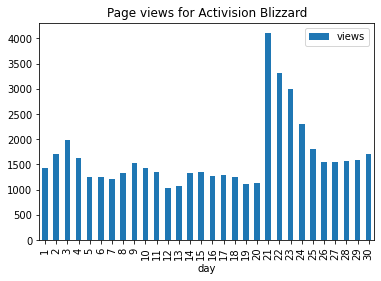

In [17]:
focused_company = 'Activision Blizzard'
(
    nasdaq_100_views
    .loc[focused_company]
    .assign(timestamp=lambda x: pd.to_datetime(x.timestamp, format='%Y%m%d%H', errors='coerce'))
    .assign(day = lambda x: x.timestamp.dt.day)
    .plot
    .bar(
        x='day', y='views',
        title=f'Page views for {focused_company}'
    )
);

## Loading from complex API

Many times API are more complex, nevertheless, we can still extract the relevant data. 

Let's get some stock data from [alphavantage.co](https://www.alphavantage.co)

This web service is providing useful investment information using an API, however, like many other API providers, it requires an API key to identify the request (and sometimes chanrge for it).

To allow usage of secrets such as the API key for the service call, we will use a simple mechanism using _.env_ file that each user should create and update with their private keys.

Once we have the module to handle secrets installed, we can import it to the notebook and use it. You can get your free API key from [alphavantage.co](https://www.alphavantage.co/support/#api-key). Next time you will execute the cell and the whole notebook, the API key will be retrieved from the local file.

In [18]:
from dotenv import load_dotenv
load_dotenv()

ALPHAVANTAGE_API_KEY = os.getenv("ALPHAVANTAGE_API_KEY")

From the [API documentation](https://www.alphavantage.co/documentation/) we can learn how to extract time-series stock information of a specific symbol. Let's use Amazon (AMZN) for example. 

In [19]:
symbol = 'AMZN'

request_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&apikey={ALPHAVANTAGE_API_KEY}'

In [20]:
df = (
    pd
    .read_json(request_url)
)

In [21]:
df

,Meta Data,Time Series (1min)
1. Information,"Intraday (1min) open, high, low, close prices ...",NaN
2. Symbol,AMZN,NaN
3. Last Refreshed,2021-03-05 20:00:00,NaN
4. Interval,1min,NaN
5. Output Size,Compact,NaN
...,...,...
2021-03-05 15:11:00,NaN,"{'1. open': '2993.4100', '2. high': '2994.0400..."
2021-03-05 15:10:00,NaN,"{'1. open': '2991.7100', '2. high': '2996.3845..."
2021-03-05 15:09:00,NaN,"{'1. open': '2990.9000', '2. high': '2992.0000..."
2021-03-05 15:08:00,NaN,"{'1. open': '2995.0000', '2. high': '2997.3695..."


## Extracting the relevant data

We see that the data that we are looking for (open, close, high and low prices and volume in each minute) is available in a column of the dataframe table. We will filter the table to include only the rows with the prices data and split it to separated columns.

* Start with the dataframe table that was returned from the API call
* Rename the long 'Time Series...' column name to short 'ts'
* Filter out all the rows where 'ts' column has no value (_null_)
* Take only the 'ts' column for all the row left
* Parse each value in the column as a series of key-value pairs and create a column for each pair

In [22]:
json_series = (
    df
    .rename(columns={'Time Series (1min)':'ts'})
    .query('ts.notnull()')
    .loc[:,'ts']
    .apply(pd.Series)
)

In [23]:
json_series

,1. open,2. high,3. low,4. close,5. volume
2021-03-05 20:00:00,3005.0000,3005.0000,3005.0000,3005.0000,316
2021-03-05 19:59:00,3004.0000,3004.0000,3004.0000,3004.0000,138
2021-03-05 19:54:00,3004.9999,3004.9999,3004.9999,3004.9999,110
2021-03-05 19:41:00,3003.9700,3003.9700,3003.9700,3003.9700,245
2021-03-05 19:36:00,3001.5000,3001.5000,3001.5000,3001.5000,493
...,...,...,...,...,...
2021-03-05 15:11:00,2993.4100,2994.0400,2991.9350,2993.4800,7873
2021-03-05 15:10:00,2991.7100,2996.3845,2991.7100,2994.5100,7801
2021-03-05 15:09:00,2990.9000,2992.0000,2987.4301,2992.0000,11182
2021-03-05 15:08:00,2995.0000,2997.3695,2991.5800,2991.5800,6006


## Quick Visualization

Now that we have the prices from the API we can plot them. 
* Start with the parsed data table above
* Convert the values to numeric form (_astype('float')_) 
* Slice the table to include only the _high_ and _low_ values (_iloc_) 
* Reverse the order of the time-series to be from oldest to newest (_iloc[::-1]_)
* Plot the data
* with the title of the ticker 
* and with 45° rotation. 

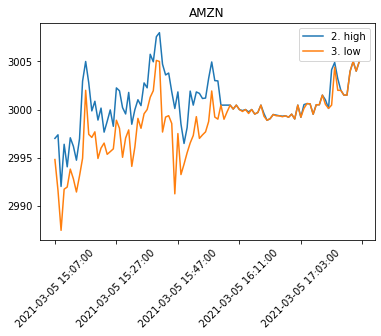

In [24]:
(
    json_series
    .astype('float')
    .loc[:,('2. high','3. low')]
    .iloc[::-1]
    .plot(
        title=symbol, 
        rot=45
    )
);